# Graph ConvNet

Neural network based on the paper: `Joshi, Laurent, and Bresson, ‘An Efficient Graph Convolutional Network Technique for the Travelling Salesman Problem’.`

Open questions:
* Difference between Linear and Embedding layer.
* Does it make a difference that no two Linear layers were used for the edge layer?
* Why are the biases disabled for eq 2 and eq 3 - in the paper they are present?
* How does Batch Normalisation work?
* How are class weights calculated
* log_softmax and NLLLoss vs CrossEntropy (CrossEntropy calculation meaning)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx

from model import GraphNet
from pathlib import Path
from torch.utils.data import DataLoader
from utils.data import Data, VRPDataset
from utils.loader import load_config
from utils.model import save_model
from sklearn.utils.class_weight import compute_class_weight

## Model Inputs

| Variable | Meaning | Dimensions |
| -------- | ------- | ---------- |
| batch_edges | Adj matrix special connections* | B x num_nodes x num_nodes
| batch_edges_values | Distance Matrix | B x num_nodes x num_nodes
| batch_edges_target | Target adj matrix | B x num_nodes x num_nodes
| batch_nodes | Ones vector | B x num_nodes
| batch_nodes_coord | Coordinates | B x num_nodes x 2
| *batch_nodes_target* | Value represents ordering in tour | B x num_nodes


*special connections:
* 1 - k-nearest neighbour
* 2 - self connections
* 0 - otherwise

In [3]:
data_dir = Path('data')

train_dataset = torch.load(data_dir / 'vrp_20_train.pt')
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [4]:
test_dataset = torch.load(data_dir / 'vrp_20_test.pt')
test_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Visualise an instance

In [5]:
def first(tensor): return tensor[0]
def get_batch(dl): return next(iter(dl))

In [6]:
batch_features, batch_targets = next(iter(train_dataloader))
coords = first(batch_features[0]).cpu().numpy()
target = first(batch_targets).cpu().numpy()

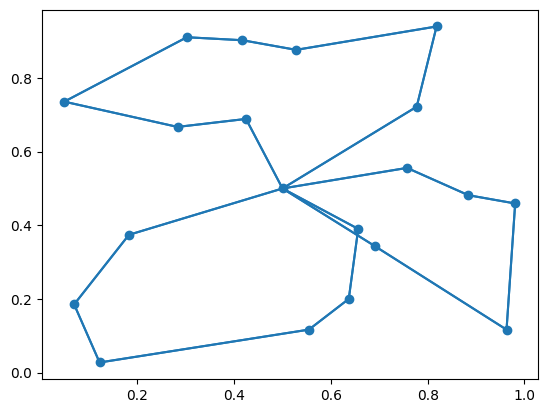

In [7]:
fig, ax = plt.subplots()

ax.scatter(coords[:, 0], coords[:, 1])

for i, row in enumerate(target):
    args = np.argwhere(row>0).flatten()
    x_i = coords[i]
    
    for x_j in coords[args]:
        ax.plot([x_i[0], x_j[0]], [x_i[1], x_j[1]], c='tab:blue')

plt.show()

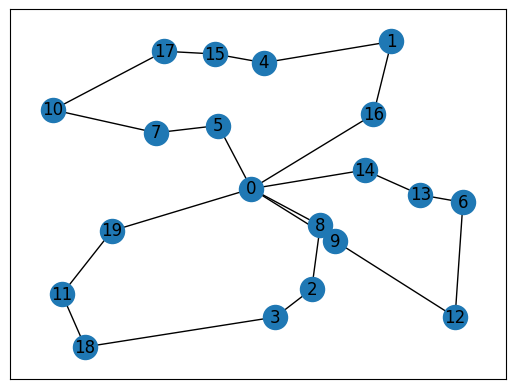

In [8]:
fig, ax = plt.subplots()

G = nx.from_numpy_array(target)
pos = dict(enumerate(coords))

nx.draw_networkx(G, pos, ax=ax)

plt.show()

## Compute class weights

Due to the class imbalance, we need to calculate the class weights.

In [9]:
targets = np.array([target_edges.cpu().numpy() for _, target_edges in train_dataset])

In [10]:
class_labels = targets.flatten()

edge_class_weights = compute_class_weight('balanced',
                                          classes=np.unique(class_labels),
                                          y=class_labels)
edge_class_weights = torch.tensor(edge_class_weights, dtype=torch.float)

In [11]:
edge_class_weights

tensor([0.5619, 4.5414])

## The Model

In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device", device)

Device cpu


In [70]:
config = load_config(num_gcn_layers=5, hidden_dim=40, node_features=3)

In [71]:
LEARNING_RATE = 0.001

model = GraphNet(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = nn.CrossEntropyLoss(edge_class_weights)

## Test Forward Pass

In [72]:
batch_coords, batch_demand, batch_edge_weights, batch_edge_values = batch_features

# ONLY A TEST
batch_node_features = torch.cat((batch_coords, batch_demand.unsqueeze(-1)), axis=-1)

y_pred = model.forward(batch_node_features, batch_edge_weights, batch_edge_values)

## Training Loop

In [73]:
def get_loss(y_pred, y_target):
    y = y_pred.permute(0, 3, 1, 2)
    
    return criterion(y, y_target)

def train_one_epoch(batch_coords, batch_demand, batch_edge_weights, batch_edge_values, batch_targets):
    model.train()
    
    optimizer.zero_grad()
    
    # ONLY A TEST
    batch_node_features = torch.cat((batch_coords, batch_demand.unsqueeze(-1)), axis=-1)
    
    y_pred = model(batch_node_features, batch_edge_weights, batch_edge_values)
    y_pred = y_pred.permute(0, 3, 1, 2)
    
    loss = criterion(y_pred, batch_targets)
    loss.backward()
    
    optimizer.step()
#     scheduler.step(loss)

    return loss

def train(num_epochs, dataloader):
    epoch_losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
    
        for batch_features, batch_targets in dataloader:
            batch_coords, batch_demand, batch_edge_weights, batch_edge_values = batch_features
            batch_coords = batch_coords.to(device)
            batch_demand = batch_demand.to(device)
            batch_edge_weights = batch_edge_weights.to(device)
            batch_edge_values = batch_edge_values.to(device)
            
            batch_targets = batch_targets.to(device)
            
            loss = train_one_epoch(batch_coords,
                                   batch_demand,
                                   batch_edge_weights,
                                   batch_edge_values,
                                   batch_targets)
            epoch_loss += loss.item()
            epoch_losses.append(epoch_loss)

        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

def eval_model(batch_coords, batch_demand, batch_edge_weights, batch_edge_values):
    model.eval()
    
    # ONLY A TEST
    batch_node_features = torch.cat((batch_coords, batch_demand.unsqueeze(-1)), axis=-1)

    with torch.no_grad():
        y_pred = model(batch_node_features, batch_edge_weights, batch_edge_values)

    return y_pred

In [74]:
train(65, train_dataloader)

Epoch: 00, Loss: 0.3074
Epoch: 01, Loss: 0.3003
Epoch: 02, Loss: 0.2613
Epoch: 03, Loss: 0.2742
Epoch: 04, Loss: 0.2606
Epoch: 05, Loss: 0.2625
Epoch: 06, Loss: 0.2678
Epoch: 07, Loss: 0.2393
Epoch: 08, Loss: 0.2515
Epoch: 09, Loss: 0.2510
Epoch: 10, Loss: 0.2577
Epoch: 11, Loss: 0.2345
Epoch: 12, Loss: 0.2434
Epoch: 13, Loss: 0.2319
Epoch: 14, Loss: 0.2226
Epoch: 15, Loss: 0.2291
Epoch: 16, Loss: 0.2420
Epoch: 17, Loss: 0.2305
Epoch: 18, Loss: 0.2268
Epoch: 19, Loss: 0.2345
Epoch: 20, Loss: 0.2108
Epoch: 21, Loss: 0.2285
Epoch: 22, Loss: 0.2109
Epoch: 23, Loss: 0.2414
Epoch: 24, Loss: 0.2176
Epoch: 25, Loss: 0.2107
Epoch: 26, Loss: 0.2095
Epoch: 27, Loss: 0.2160
Epoch: 28, Loss: 0.2135
Epoch: 29, Loss: 0.2019
Epoch: 30, Loss: 0.2027
Epoch: 31, Loss: 0.1988
Epoch: 32, Loss: 0.2060
Epoch: 33, Loss: 0.2097
Epoch: 34, Loss: 0.2283
Epoch: 35, Loss: 0.1977
Epoch: 36, Loss: 0.2405
Epoch: 37, Loss: 0.2114
Epoch: 38, Loss: 0.2055
Epoch: 39, Loss: 0.2011
Epoch: 40, Loss: 0.1990
Epoch: 41, Loss:

In [76]:
save_model(model, filename='model_20_65.pt')

In [90]:
batch_features, batch_targets = get_batch(test_dataloader)
batch_coords, batch_demands, batch_edge_dist, batch_edge_feat = batch_features

In [91]:
preds = eval_model(batch_coords, batch_demand, batch_edge_dist, batch_edge_feat)

In [92]:
preds = F.softmax(preds, dim=3)
preds = preds.argmax(dim=3)
preds = preds.cpu().numpy()

In [93]:
def adj_matrix_to_list(adj_matrix):
    adj_list = []
    
    for i, row in enumerate(adj_matrix):
        dest = np.argwhere(row>0).flatten()
        src = np.full(dest.size, i)
        
        adj_list.extend(zip(src, dest))
    
    return adj_list

In [94]:
def plot_edge_predictions(coords, pred, target, ax):
    G = nx.from_numpy_array(target)
    pos = dict(enumerate(coords))
    
    pred_edge_list = adj_matrix_to_list(pred)

    nx.draw_networkx(G, pos, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=pred_edge_list, edge_color='red', alpha=0.1, width=3, ax=ax)

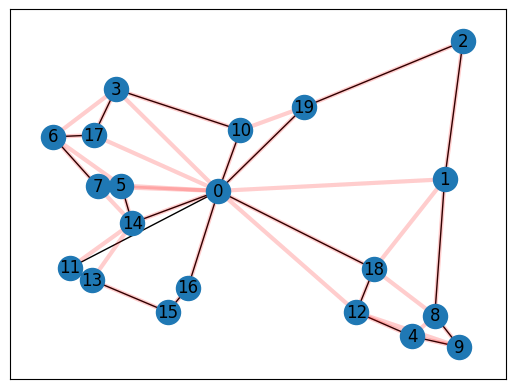

In [95]:
fig, ax = plt.subplots()
i = 5
plot_edge_predictions(batch_coords[i].cpu().numpy(), preds[i], batch_targets[i].cpu().numpy(), ax=ax)

In [96]:
def edge_errors(preds, targets):
    # how many true connections did it predict
    acc = (preds == targets).astype(int)
    # mask to ignore false predictions
    mask = np.copy(targets)
    acc = acc * targets

    acc = acc.sum(axis=2).sum(axis=1) / targets.sum(axis=2).sum(axis=1)
    acc = acc.mean()
    err_true_connection = 1 - acc
    
    # how many false connections did it predict
    acc = (preds == targets).astype(int)
    # mask to ignore false predictions (invert)
    mask = np.copy(targets)
    mask[targets==0] = 1
    mask[targets==1] = 0
    acc = acc * mask
    
    acc = acc.sum(axis=2).sum(axis=1) / mask.sum(axis=2).sum(axis=1)
    acc = acc.mean()
    err_false_connection = 1 - acc
    
    return err_true_connection, err_false_connection

In [97]:
targets = batch_targets.cpu().numpy()

true_edge_error, false_edge_error = edge_errors(preds, targets)
print(f"Correct: {true_edge_error:.2%}")
print(f"Wrong: {false_edge_error:.2%}")

Correct: 5.40%
Wrong: 11.32%


In [98]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

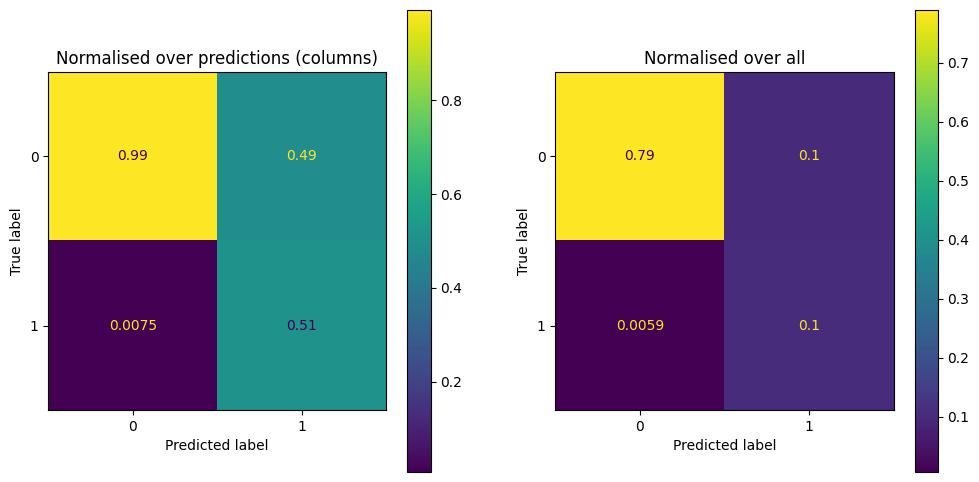

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay.from_predictions(targets.flatten(), preds.flatten(), normalize='pred', ax=axes[0])
ConfusionMatrixDisplay.from_predictions(targets.flatten(), preds.flatten(), normalize='all', ax=axes[1])
axes[0].set_title("Normalised over predictions (columns)")
axes[1].set_title("Normalised over all")

plt.show()

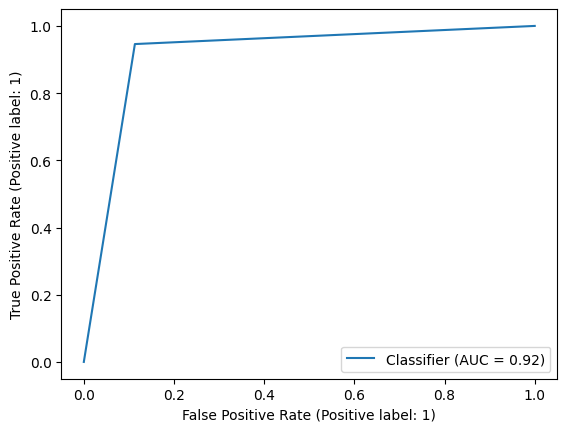

In [100]:
RocCurveDisplay.from_predictions(targets.flatten(), preds.flatten())

plt.show()